In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mplimg
from matplotlib.colors import DivergingNorm

# ML
from soap import compute_soap_density, reshape_soaps
from soap import rrw_neighbors, make_tuples
from soap import extract_species_pair_groups

# Utilities
import h5py
import json
import re
import project_utils as utils
from tools import load_json

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [3]:
#def make_plot(output, density, r_grid, p_grid, species_pair_label, neighbors=None):
# TODO: scatter points only for selected environments?
def make_plot(output, r_grid, p_grid, density, density_highlight=None,
              rrw_neighbors=None, idxs_neighbors=None, 
              species_pair_idx=None, species_pair_name=None,
              scatter=False, annotate=[]):
    
    # Camera view settings
    x = -1.25
    y = -1.25
    z = 1.25

    # Compute aspect ratio from data
    # so we can set it manually including zoom
    # TODO: make this compatible with differing r_grid and p_grid sizes
    zoom = 1.0
    aspect_ratio_keys = ['x', 'y', 'z']
    xyz_max = np.amax(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_min = np.amin(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_ratios = np.abs(xyz_max - xyz_min)
    xyz_ratios = xyz_ratios / xyz_ratios[0] * zoom
    xyz_ratios[2] *= xyz_ratios[0] / xyz_ratios[2] # Make cube

    aspect_ratio = {key: value for key, value in zip(aspect_ratio_keys, xyz_ratios)}
    
    annotations = []
    
    # Plot
    rx_grid, ry_grid, pz_grid = np.meshgrid(r_grid, r_grid, p_grid, indexing='ij')
    
    avg = np.mean(density)
    std = np.std(density)
    
    avg_highlight = np.mean(density_highlight)
    std_highlight = np.std(density_highlight)

    fig = go.Figure()
    fig.add_trace(
        go.Isosurface(
            x=rx_grid.flatten(),
            y=ry_grid.flatten(),
            z=pz_grid.flatten(),
            value=density.flatten(),
            coloraxis='coloraxis1',
            isomin=avg - 2.0*std,
            isomax=avg + 2.0*std,
            opacity=0.3,
            surface_count=4,
            caps=dict(x_show=False, y_show=False, z_show=False)
        )
    )
        
    if density_highlight is not None:
        fig.add_trace(
            go.Volume(
                x=rx_grid.flatten(),
                y=ry_grid.flatten(),
                z=pz_grid.flatten(),
                value=density_highlight.flatten(),
                coloraxis='coloraxis2',
                isomin=avg_highlight - 2.0*std_highlight,
                isomax=avg_highlight + 2.0*std_highlight,
                opacity=0.4,
                surface_count=2,
                caps=dict(x_show=False, y_show=False, z_show=False)
            )
        )

    if rrw_neighbors is not None and species_pair_idx is not None:
        atom_stencils = [[], [], []]
        for xyz in range(0, len(atom_stencils)):
            atom_stencils[xyz] = np.concatenate(
                [center[species_pair_idx][xyz].flatten() for center in rrw_neighbors]
            )

        if idxs_neighbors is not None:
            idxs = [[], [], []]
            for xyz in range(0, len(idxs)):
                idxs[xyz] = np.concatenate(
                    [center[species_pair_idx][xyz].flatten() for center in idxs_neighbors]
                )
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j, k): %{text}'
            hovertext = ['{}'.format(i) for i in zip(idxs[0], idxs[1], idxs[2])]
        else:
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}'
            hovertext=None

        if scatter:
            fig.add_trace(
                go.Scatter3d(
                    x=atom_stencils[0],
                    y=atom_stencils[1],
                    z=atom_stencils[2],
                    name=f'{species_pair_name}',
                    mode='markers',
                    marker=dict(size=5, color='purple'),
                    hovertemplate=hovertemplate,
                    text=hovertext,
                    showlegend=False
                )
            )
        
        for center in annotate:
            annotations.append(dict(
                showarrow=True,
                x=atom_stencils[0][center],
                y=atom_stencils[1][center],
                z=atom_stencils[2][center],
                hovertext=f'(i, j, k): {hovertext}',
                text=f'{center}',
                arrowcolor='Black',
                arrowsize=1,
                arrowwidth=2,
                ax=50,
                ay=-50,
                xshift=5,
                yshift=5,
            ))
                
    font_size = 18
    species_pair_title = '-'.join(re.findall('[A-Z][a-z]*', species_pair_name))
    fig.update_layout(
        template='simple_white',
        title=dict(
            text=f'Si-<b>{species_pair_title}</b>',
            font=dict(size=2.0 * font_size),
            x=0.5, y=0.85,
            xanchor='center',
            yanchor='top'
        ),
        scene=dict(
            xaxis=dict(
                title=dict(text='r', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            yaxis=dict(
                title=dict(text='r\'', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            zaxis=dict(
                title=dict(text='w', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            annotations=annotations,
            camera=dict(
                eye=dict(x=-1.25, y=-1.25, z=1.25),
                projection=dict(type='orthographic')
            ),
            aspectratio=aspect_ratio
        ),
        legend=dict(
            x=0.0, y=1.0,
            xanchor='left', yanchor='top',
            itemsizing='constant'
        ),
        coloraxis1=dict(
            colorscale='RdBu',
            colorbar=dict(
                title=dict(
                    text='Weights*Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5,
                x=-0.02, xanchor='right'
            ),
        ),
        coloraxis2=dict(
            colorscale='Purples',
            colorbar=dict(
                title=dict(
                    text='Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5
            ),
        ),
        font=dict(size=14, family='helvetica, sans-serif'),
        autosize=False, width=800, height=800,
        #margin=dict(t=5, b=5)
    )
    
    fig.show()

    fig.write_html(f'{output}.html')
    fig.write_image(f'{output}.pdf')

# TODO: also do combinations of species pairs for the power spectrum

# Setup

In [4]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters.pop('interaction_cutoff')

In [5]:
n_Si_deem = np.loadtxt('../../Processed_Data/DEEM_10k/n_Si.dat', dtype=int)
n_Si_iza = np.loadtxt('../../Processed_Data/IZA_226/n_Si.dat', dtype=int)

OSError: ../../Processed_Data/DEEM_10k/n_Si.dat not found.

In [6]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/idxs_bk/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/idxs_bk/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [7]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/idxs_bk/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/idxs_bk/test.idxs', dtype=int)

In [8]:
# Set grids
# TODO: load grids?
n_r_grid = 100
chunk_size_r = 10
r_grid = {}
for cutoff in cutoffs:
    r_grid[cutoff] = np.linspace(0.0, cutoff*1.5, n_r_grid) ###

n_p_grid = 50
chunk_size_p = 10
p_grid = np.linspace(-1.0, 1.0, n_p_grid)

In [9]:
# Linear model setup
n_species = 2
#group_names = {'power': ['OO', 'OSi', 'SiSi', 
#                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
#                         'OO+OSi+SiSi'], 
#               'radial': ['O', 'Si', 'O+Si']}
group_names = {'power': ['OO', 'OSi', 'SiSi'],
               'radial': ['O', 'Si']}

In [10]:
model_dir = '../../Processed_Data/Models'

# TODO: load just from the 330k
deem_name = 'DEEM_10k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

# TMP: Load structures

In [11]:
from ase.io import read
from soap import librascal_soap

In [12]:
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
codes_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=0, dtype=str)
RWY = np.nonzero(cantons_iza == 4)[0][0]

In [123]:
# TODO: replace this with better infrastructure
from numpy.random import default_rng
n_random = 50

deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)
deem_idx = np.arange(0, 331172) # Need length of deem
deem_idx = np.delete(deem_idx, deem_delete)
rng = default_rng(seed=78390)
rng.shuffle(deem_idx)
deem_idx = deem_idx[0:n_random]
deem_idx_sort = np.argsort(deem_idx)
deem_idx_rev = np.argsort(deem_idx_sort)

iza_idx = np.arange(0, len(cantons_iza))
iza_idx = np.delete(iza_idx, RWY)
rng = default_rng(seed=82437)
rng.shuffle(iza_idx)
iza_idx = iza_idx[0:n_random]
iza_idx_sort = np.argsort(iza_idx)
iza_idx_rev = np.argsort(iza_idx_sort)

## Power spectrum

In [ ]:
soaps_sod = {}
density_sod = {}
sod_neighbor_rrw = {}
sod_neighbor_idxs = {}
for cutoff in cutoffs:
    
    # Compute SOAPs
    soaps_sod[cutoff] = librascal_soap(
        sod, [14],
        **soap_hyperparameters,
        soap_type='PowerSpectrum',
        interaction_cutoff=cutoff,
        normalize=False,
        average=True
    )
    
    soaps_sod[cutoff] = soaps_sod[cutoff][0]
    
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'
    iza_file = f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'    

    # Build average IZA and DEEM SOAP over the whole dataset instead of per-structure
    soaps_deem = utils.load_hdf5(deem_file, datasets=None, concatenate=True)

    soaps_iza = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza = np.delete(soaps_iza, RWY, axis=0)

    # Scale SOAPs to be compatible with the weights
    soaps_scale = np.std(np.concatenate((soaps_iza[idxs_iza_train], soaps_deem[idxs_deem_train])))
    
    soaps_sod[cutoff] /= soaps_scale

    soaps_sod[cutoff] = reshape_soaps(
        soaps_sod[cutoff], 3, 
        soap_hyperparameters['max_radial'], 
        soap_hyperparameters['max_angular']
    )

    # Compute power spectrum density
    density_sod[cutoff] = compute_soap_density(
        soaps_sod[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff],
        soap_hyperparameters['max_angular'], p_grid, 
        chunk_size_r=10, chunk_size_p=10
    )    
    
    sod_neighbor_rrw[cutoff], sod_neighbor_idxs[cutoff] = \
        rrw_neighbors(sod[0], [14], [8, 14], cutoff, self_interaction=True)

In [ ]:
for cutoff in cutoffs:
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    #for spectrum_type in ('power', 'radial'):
    for spectrum_type in ['power']:
        spectrum_name = spectrum_type.capitalize()        
        
        for gdx, group_name in enumerate(group_names[spectrum_type]):
            deem_file = f'{deem_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            iza_file = f'{iza_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            
            hdf5_deem = h5py.File(deem_file, 'r')
            hdf5_iza = h5py.File(iza_file, 'r')
            
            soaps_deem = hdf5_deem['0'][:]
            soaps_deem *= np.sum(n_Si_deem)
            soaps_iza = hdf5_iza['0'][:] * np.sum(n_Si_iza)
            soaps_avg = (soaps_iza + soaps_deem) / (np.sum(n_Si_iza) + np.sum(n_Si_deem))
            
            hdf5_deem.close()
            hdf5_iza.close()
            
            partial_density_sod = density_sod[cutoff][:, gdx, ...]
            
            # TODO: how to handle multiple decision functions?
            #for n_cantons in (2, 4):
            for n_cantons in [2]:
                
                output = f'../../Results/{cutoff}/real_space_overlap_{cutoff}_{n_cantons}-class_{spectrum_type}_{group_name}'
                
                weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
                weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'
                
                hdf5_weights = h5py.File(weights_file, 'r')
                weights = hdf5_weights['0'][:]
                
                hdf5_weights.close()
                
                overlap = weights * soaps_avg

                make_plot(
                    output, 
                    r_grid[cutoff], p_grid,
                    weights.squeeze(),
                    #weights.squeeze() * partial_density_sod.squeeze(), 
                    partial_density_sod.squeeze(), 
                    rrw_neighbors=sod_neighbor_rrw[cutoff],
                    idxs_neighbors=sod_neighbor_idxs[cutoff],
                    species_pair_idx=gdx,
                    species_pair_name=group_name,
                    scatter=True, annotate=[]
                )

## Radial spectrum

In [114]:
# Linear model setup
n_species = 2
#group_names = {'power': ['OO', 'OSi', 'SiSi', 
#                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
#                         'OO+OSi+SiSi'], 
#               'radial': ['O', 'Si', 'O+Si']}
group_names = {'power': ['OO', 'OSi', 'SiSi'],
               'radial': ['O', 'Si', 'O+Si']} # Try the combination with the radial spectrum

## SOD

In [115]:
# TODO: remove the below once we have better infrastructure

In [116]:
soaps_scale = {}

In [117]:
soaps_sod = {}
soaps_sod_raw = {}
density_sod = {}
sod_neighbor_rrw = {}
sod_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_sod[cutoff] = librascal_soap(
#         sod, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_sod[cutoff] = soaps_sod[cutoff][0]
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'{deem_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'
    iza_file = f'{iza_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'    

    # Build average IZA and DEEM SOAP over the whole dataset instead of per-structure
    soaps_deem = utils.load_hdf5(deem_file, datasets=None, concatenate=True)

    soaps_iza = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza = np.delete(soaps_iza, RWY, axis=0)

    # Scale SOAPs to be compatible with the weights
    soaps_scale[cutoff] = np.std(np.concatenate((soaps_iza[idxs_iza_train], soaps_deem[idxs_deem_train])))
    
    soaps_sod[cutoff] = soaps_iza[189].copy() # Try this? The SOD soap vectors don't seem to be consistent
    
    soaps_sod[cutoff] /= soaps_scale[cutoff]
    soaps_sod_raw[cutoff] = soaps_sod[cutoff].copy()

    soaps_sod[cutoff] = reshape_soaps(
        soaps_sod[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_sod[cutoff] = compute_soap_density(
        soaps_sod[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )

In [118]:
soaps_sod_raw[6.0]

array([ 1.04498449e-01, -2.49067552e-01,  1.57110961e+00,  2.30541000e+00,
        2.96275848e-01, -4.80780231e-01,  1.36848917e+00,  2.14453168e+00,
        8.14407187e-01,  2.11921117e+00,  1.39839135e+00,  7.07862477e-01,
        3.75198105e+00,  8.99445168e-02, -8.00472203e-02, -1.24208943e-01,
        2.79020610e-02,  9.08501759e-01,  1.04662908e+00, -3.47336823e-03,
        4.22385716e-01,  1.22984101e+00,  9.20348554e-01,  4.41006384e-01])

In [119]:
soaps_iza[189] / soaps_scale[6.0]

array([ 1.04498449e-01, -2.49067552e-01,  1.57110961e+00,  2.30541000e+00,
        2.96275848e-01, -4.80780231e-01,  1.36848917e+00,  2.14453168e+00,
        8.14407187e-01,  2.11921117e+00,  1.39839135e+00,  7.07862477e-01,
        3.75198105e+00,  8.99445168e-02, -8.00472203e-02, -1.24208943e-01,
        2.79020610e-02,  9.08501759e-01,  1.04662908e+00, -3.47336823e-03,
        4.22385716e-01,  1.22984101e+00,  9.20348554e-01,  4.41006384e-01])

## DEEM

In [124]:
soaps_deem_ex = {}
soaps_deem_ex_raw = {}
density_deem_ex = {}
deem_ex_neighbor_rrw = {}
deem_ex_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_deem_ex[cutoff] = librascal_soap(
#         deem_ex, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_deem_ex[cutoff] = np.mean(soaps_deem_ex[cutoff], axis=0)
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'../../Processed_Data/DEEM_330k/Data/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'

    soaps_deem_ex[cutoff] = utils.load_hdf5(deem_file, indices=deem_idx[deem_idx_sort])
    soaps_deem_ex[cutoff] = soaps_deem_ex[cutoff][deem_idx_rev] # TODO: check this
        
    soaps_deem_ex[cutoff] /= soaps_scale[cutoff]
    soaps_deem_ex_raw[cutoff] = soaps_deem_ex[cutoff].copy()

    soaps_deem_ex[cutoff] = reshape_soaps(
        soaps_deem_ex[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_deem_ex[cutoff] = compute_soap_density(
        soaps_deem_ex[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )
    
    # TODO: avg Deem

## IZA

In [157]:
soaps_iza_ex = {}
soaps_iza_ex_raw = {}
density_iza_ex = {}
iza_ex_neighbor_rrw = {}
iza_ex_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_iza_ex[cutoff] = librascal_soap(
#         iza_ex, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_iza_ex[cutoff] = np.mean(soaps_iza_ex[cutoff], axis=0)
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    iza_file = f'../../Processed_Data/IZA_226/Data/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'

    soaps_iza_ex[cutoff] = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza_ex[cutoff] = soaps_iza_ex[cutoff][iza_idx]
    #soaps_iza_ex[cutoff] = soaps_iza_ex[cutoff][idxs_iza_train]
        
    soaps_iza_ex[cutoff] /= soaps_scale[cutoff]
    soaps_iza_ex_raw[cutoff] = soaps_iza_ex[cutoff].copy()

    soaps_iza_ex[cutoff] = reshape_soaps(
        soaps_iza_ex[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_iza_ex[cutoff] = compute_soap_density(
        soaps_iza_ex[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )

# Plot

-12.325382370640796 25.24555109918783
-10.530207311979382 16.731845779689117
-12.668648079967486 25.042570837043552
-10.16287384639329 13.013991681468863
-8.980265476773438 12.819306298146273
-7.542728937552056 15.671603930184158


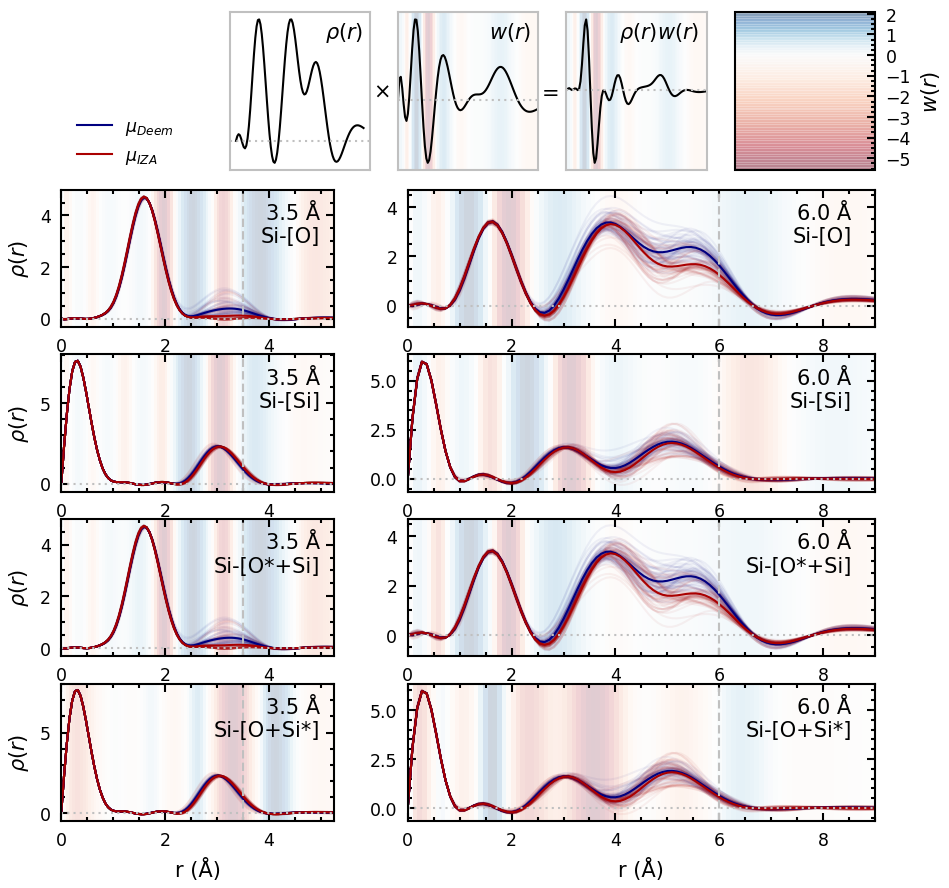

In [182]:
fig = plt.figure(figsize=(7.0, 7.0))
n_cols = 2
n_rows = 4
n_schematic = 2 * n_cols + 1

gs = fig.add_gridspec(
    nrows=2, ncols=1,
    height_ratios=(0.25, 1.0),
    hspace=0.05, wspace=0.05
)

schematic_gs = gs[0].subgridspec(1, n_schematic)

max_cutoff = np.amax(cutoffs)
width_ratios = [c / max_cutoff for c in cutoffs]
data_gs = gs[-1].subgridspec(n_rows, n_cols, width_ratios=width_ratios)

data_axes = np.array([[fig.add_subplot(data_gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)]) 
schematic_axes = np.array([fig.add_subplot(schematic_gs[i]) for i in range(n_schematic//2-1, n_schematic//2+2)])

for cdx, cutoff in enumerate(cutoffs):
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    spectrum_type = 'radial'
    spectrum_name = spectrum_type.capitalize()       
     
    plot_idx = 0
    for gdx, group_name in enumerate(group_names[spectrum_type]):

        n_species_plot = group_name.count('+') + 1
        if n_species_plot > 1:
            partial_density_sod = density_sod[cutoff][:]
            partial_density_deem = density_deem_ex[cutoff][:]
            partial_density_iza = density_iza_ex[cutoff][:]
        else:
            partial_density_sod = density_sod[cutoff][:, gdx, :][:, np.newaxis, :]
            partial_density_deem = density_deem_ex[cutoff][:, gdx, :][:, np.newaxis, :]
            partial_density_iza = density_iza_ex[cutoff][:, gdx, :][:, np.newaxis, :]

        n_features = len(soaps_sod_raw[cutoff])

        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        fdxs = feature_groups[gdx]
                
        # TODO: how to handle multiple decision functions?
        #for n_cantons in (2, 4):
        for n_cantons in [2]:
            
            output = f'../../Results/{cutoff}/real_space_overlap_{n_cantons}-class_{spectrum_type}_{group_name}'

            weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
            weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'

            hdf5_weights = h5py.File(weights_file, 'r')
            weights = hdf5_weights['0'][:]
            hdf5_weights.close()
            
            full_weights = np.loadtxt(f'{weights_dir}/svc_weights.dat')

            intercept = load_json(f'{weights_dir}/svc.json', array_convert=True)['intercept_'][0]

            # Make the radial plot
            group_title = '-'.join(re.findall('[A-Z][a-z]*', group_name))
            species_txt = group_name.split('+')

            print(np.amin(weights), np.amax(weights))
            
            for n in range(0, n_species_plot):
                axs = data_axes[plot_idx, cdx]
                
                for pds in partial_density_deem:
                    axs.plot(r_grid[cutoff], pds[n], color=color_list[2], alpha=0.05)

                for pds in partial_density_iza:
                    axs.plot(r_grid[cutoff], pds[n], color=color_list[1], alpha=0.05)
                    
                # TODO: replace the Deem and IZA averages with over the whole database, not just the
                # random selection
                axs.plot(
                    r_grid[cutoff], np.mean(partial_density_deem[:, n, :], axis=0), 
                    color=color_list[2], label=r'$\mu_{Deem}$'
                )

                axs.plot(
                    r_grid[cutoff], np.mean(partial_density_iza[:, n, :], axis=0), 
                    color=color_list[1], label=r'$\mu_{IZA}$'
                )

                axs.axhline(0.0, linestyle=':', color=color_list[9])
                axs.axvline(cutoff, linestyle='--', color=color_list[9])

#                 axs.plot(r_grid[cutoff], weights[:, n, :].squeeze(), color=color_list[0])

                # Background weights
                extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
                w_plot = axs.imshow(
                    weights[:, n, :], extent=extent, aspect='auto', 
                    norm=DivergingNorm(0.0), cmap='RdBu',
                    alpha=0.2,
                    zorder=0
                )
            
                st = species_txt.copy()
                if n_species_plot > 1:
                    st[n] = f'{st[n]}*'
                
                st = '+'.join(st)
                
#                 with plt.rc_context(rc={'text.usetex': True}):
#                     axs.text(
#                         0.95, 0.90, f'{cutoff} ' + u'\u00c5\n' + fr'Si-\textbf{{{st}}}',
#                         horizontalalignment='right', verticalalignment='top',
#                         transform=axs.transAxes
#                     )
                axs.text(
                    0.95, 0.90, f'{cutoff} ' + u'\u00c5\n' + fr'Si-[{st}]',
                    horizontalalignment='right', verticalalignment='top',
                    transform=axs.transAxes
                )
                
                plot_idx += 1
                     
            # Make schematic plot
            # TODO: make weights a background
            # TODO: take this out of the loop
            labels = [r'$\rho(r)$', r'$w(r)$', r'$\rho(r) w(r)$']
            if group_name == 'O' and cdx == 1:
                pds = partial_density_sod.squeeze()
                w = weights.squeeze(axis=1)
                
                # Density
                schematic_axes[0].plot(r_grid[cutoff], pds, color=color_list[0])
                schematic_axes[0].text(
                    0.95, 0.95, r'$\rho(r)$',
                    horizontalalignment='right', verticalalignment='top',
                    transform=schematic_axes[0].transAxes
                )
                
                # Weights * Density
                schematic_axes[2].plot(r_grid[cutoff], pds*w.squeeze(), color=color_list[0])
                schematic_axes[2].text(
                    0.95, 0.95, r'$\rho(r) w(r)$',
                    horizontalalignment='right', verticalalignment='top',
                    transform=schematic_axes[2].transAxes
                )
                
                # Weights (do this after the combined so the y axes limits are correct)
                schematic_axes[1].plot(r_grid[cutoff], w.squeeze(), color=color_list[0])
                for axs in schematic_axes[1:]:
                    extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
                    axs.imshow(
                        w, extent=extent, aspect='auto', 
                        norm=DivergingNorm(0.0), cmap='RdBu',
                        alpha=0.2,
                        zorder=0
                    )
                
                schematic_axes[1].text(
                    0.95, 0.95, r'$w(r)$',
                    horizontalalignment='right', verticalalignment='top',
                    transform=schematic_axes[1].transAxes
                )
                    
                for axs in schematic_axes:
                    axs.tick_params(
                        axis='both', which='both',
                        left=False, bottom=False, top=False, right=False,
                        labelleft=False, labelbottom=False, labeltop=False, labelright=False
                    )
                    axs.axhline(0.0, color=color_list[9], linestyle=':')

                    
                schematic_axes[1].set_ylabel(
                    r'$\times$', rotation='horizontal', 
                    horizontalalignment='right', verticalalignment='center'
                )
                schematic_axes[2].set_ylabel(
                    r'$=$', rotation='horizontal',
                    horizontalalignment='right', verticalalignment='center'
                )
                        
                # Fade the frame
                for edge in ['top', 'bottom', 'left', 'right']:
                    for axs in schematic_axes:
                        axs.spines[edge].set_color(color_list[9])
                            
for axs in data_axes[:, 0]:
    axs.set_ylabel(r'$\rho(r)$')

for axs in data_axes[-1, :]:
    axs.set_xlabel('r ' + u'(\u00c5)')
                                                    
data_axes[0, 0].legend(loc='center left', bbox_to_anchor=(0.0, 1.35))

# TODO: same colorbar for all? Or separate for each species set?
fig.colorbar(w_plot, cax=fig.add_subplot(schematic_gs[-1]), aspect=100, label=r'$w(r)$')

#fig.savefig('../../Results/real_space_overlap_2-class_radial.pdf', bbox_inches='tight')

plt.show()

# Plot basis functions

In [ ]:
from soap import gto_sigma, gto_overlap, gto
from scipy.linalg import fractional_matrix_power

In [ ]:
R_n = {}
for cutoff in cutoffs:
    
    # Setup grids of the expansion orders
    n_grid = np.arange(0, soap_hyperparameters['max_radial'])
    sigma_grid = gto_sigma(cutoff, n_grid, soap_hyperparameters['max_radial'])

    # Compute radial normalization factor based on the GTO overlap
    S = gto_overlap(n_grid[:, np.newaxis],
                    n_grid[np.newaxis, :],
                    sigma_grid[:, np.newaxis],
                    sigma_grid[np.newaxis, :])
    S = fractional_matrix_power(S, -0.5)

    # Compute GTOs, shape (n_max, len(r_grid))
    R_n[cutoff] = np.matmul(S, gto(r_grid[cutoff][np.newaxis, :],
                            n_grid[:, np.newaxis],
                            sigma_grid[:, np.newaxis]))

In [ ]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(3.5, 3.5))
    axs = fig.add_subplot(1, 1, 1)
    
    for rdx, r_n in enumerate(R_n[cutoff]):
        axs.plot(r_grid[cutoff], r_n, label=f'n = {rdx+1}')
        axs.axvline(cutoff, linestyle='--', color=color_list[9])
        
plt.show()